**Time Series Forecasting Using ARIMA**

**Tujuan:** Mengembangkan model prediksi kuantitas penjualan harian produk Kalbe Nutritionals. Model ini akan membantu tim inventory melakukan perencanaan persediaan stok harian yang cukup dan memadai.


In [1]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.2 MB/s eta 0:00:00


# Import Library

In [80]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import Data

In [6]:
df_store = pd.read_csv('Store.csv', sep= ';')
df_product = pd.read_csv('Product.csv', sep= ';')
df_customer = pd.read_csv('Customer.csv', sep= ';')
df_transaction = pd.read_csv('Transaction.csv', sep= ';')

# Data Preparation

In [9]:
df1 = pd.merge(df_transaction, df_customer, on = 'CustomerID', how = 'inner')
df2 = pd.merge(df1, df_store, on = 'StoreID', how = 'inner')
df_merged = pd.merge(df2, df_product, on = 'ProductID', how = 'inner')
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,Price_y
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers,7500


In [10]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price_x         5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          5020 non-null   object
 12  StoreName       5020 non-null   object
 13  GroupStore      5020 non-null   object
 14  Type            5020 non-null   object
 15  Latitude        5020 non-null   object
 16  Longitude       5020 non-null   object
 17  Product Name    5020 non-null   object
 18  Price_y 

In [11]:
# drop price_y
df_merged.drop(columns ='Price_y', inplace = True)

In [12]:
df_merged.isna().sum()


TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
Product Name       0
dtype: int64

In [13]:
# missing value marital status
df_merged.dropna(inplace = True)
df_merged.isna().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price_x           0
Qty               0
TotalAmount       0
StoreID           0
Age               0
Gender            0
Marital Status    0
Income            0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
Product Name      0
dtype: int64

In [14]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4976 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   4976 non-null   object
 1   CustomerID      4976 non-null   int64 
 2   Date            4976 non-null   object
 3   ProductID       4976 non-null   object
 4   Price_x         4976 non-null   int64 
 5   Qty             4976 non-null   int64 
 6   TotalAmount     4976 non-null   int64 
 7   StoreID         4976 non-null   int64 
 8   Age             4976 non-null   int64 
 9   Gender          4976 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          4976 non-null   object
 12  StoreName       4976 non-null   object
 13  GroupStore      4976 non-null   object
 14  Type            4976 non-null   object
 15  Latitude        4976 non-null   object
 16  Longitude       4976 non-null   object
 17  Product Name    4976 non-null   object
dtypes: int64

In [17]:
# Convert "Date" column to YY-MM-DD

df_merged['Date'] = pd.to_datetime(df_merged['Date'])

In [18]:
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers


# Total Quantity per Day



In [30]:
df_totalquantity = df_merged.groupby('Date').agg({'Qty':'sum'})

In [31]:
df_totalquantity.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Qty     365 non-null    int64
dtypes: int64(1)
memory usage: 5.7 KB


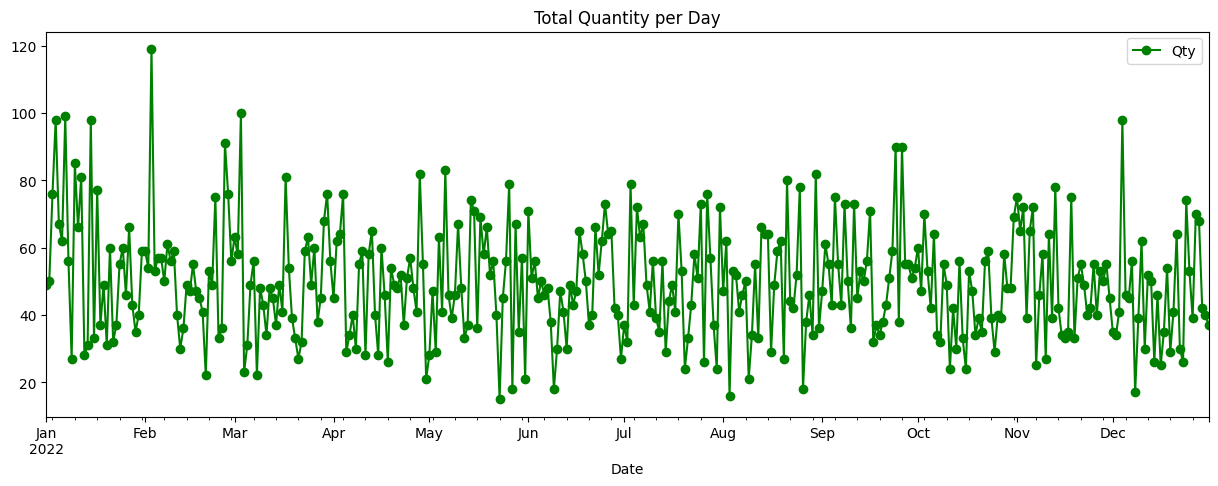

In [42]:
from pylab import rcParams

rcParams['figure.figsize'] = 15, 5
df_totalquantity.plot(color = 'g', marker = 'o')
plt.title('Total Quantity per Day')
plt.show()

In [78]:
# Split Data Train dan Data Test
print(df_totalquantity.shape)
test_size = round(df_totalquantity.shape[0] * 0.15)
train=df_totalquantity.iloc[:-1*(test_size)]
test=df_totalquantity.iloc[-1*(test_size):]
print(train.shape,test.shape)

(365, 1)
(310, 1) (55, 1)


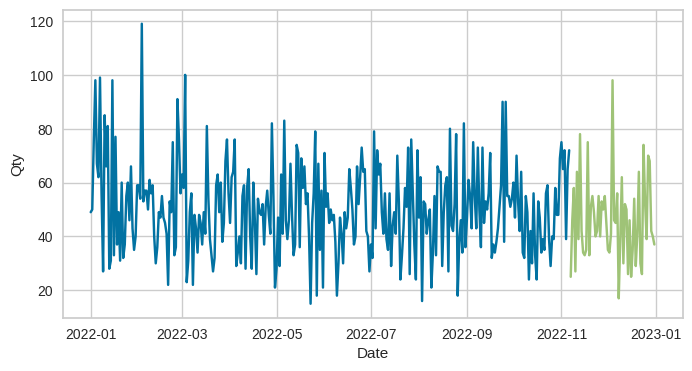

In [81]:
plt.figure(figsize=(8,4))
sns.lineplot(data=train, x=train.index, y=train['Qty'])
sns.lineplot(data=test, x=test.index, y=test['Qty'])
plt.show()

# Stationary Test

In [75]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

adfuller_test(df_totalquantity['Qty'])

ADF Test Statistic : -19.091513872408132
p-value : 0.0
#Lags Used : 0
Number of Observations : 364


In [46]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df_totalquantity)

1. ADF :  -19.091513872408132
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


*P-Value < 0,05 sehingga data stationery dapat digunakan dalam analisis time series dengan ARIMA.*

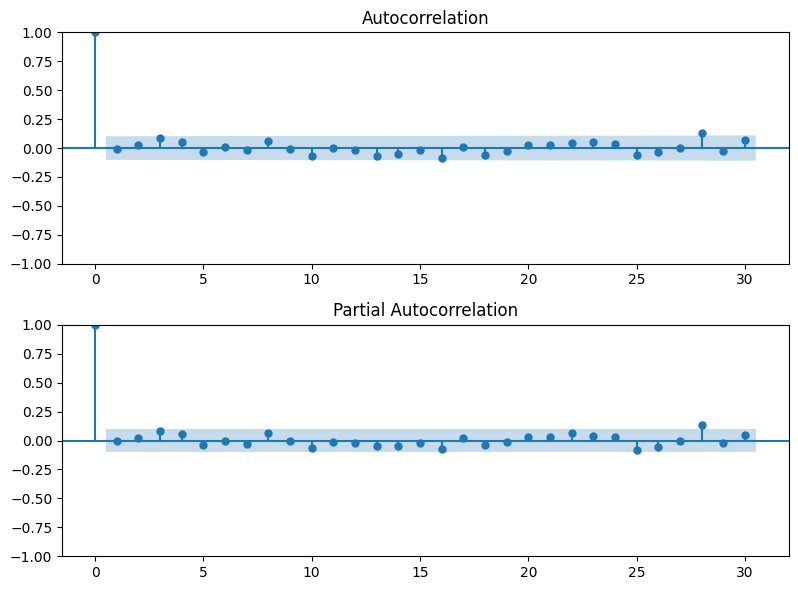

In [66]:
# Plot ACF dan PACF untuk menentukan nilai p, d, dan q

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
plot_acf(df_totalquantity['Qty'], lags=30, ax=ax1)
plot_pacf(df_totalquantity['Qty'], lags=30, ax=ax2)

plt.tight_layout()
plt.show()

p = 2 q = 4 d = 0

# Modelling

ARIMA

In [82]:
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [67]:
aic_scores = []

# Fit model ARIMA
model = ARIMA(df_totalquantity['Qty'], order=(4,0,4))
model_fit = model.fit()

# Menambahkan skor AIC ke list
aic_scores.append({'par': '(4,0,4)', 'aic': model_fit.aic})

In [68]:
aic_scores

[{'par': '(4,0,4)', 'aic': 3097.6847072257374}]

# Hyperparameter Tuning

In [108]:
from itertools import product

# Membuat list untuk p, d, dan q
p = range(0, 5)  # 0 to 7
d = range(0, 3)  # 0 to 2
q = range(0, 5)  # 0 to 7

# Menggunakan fungsi product dari itertools untuk membuat kombinasi p, d, dan q
pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4), (4, 2, 0), (4, 2, 1), (4, 2, 2), (4, 2, 3), (4, 2, 4)]


Mencari grid Manual untuk menemukan kombinasi parameter optimal (p, d, q) untuk model ARIMA berdasarkan nilai AIC terendah.

In [109]:
# daftar untuk menyimpan skor AIC
aic_scores = []

# grid manual untuk mencari p, d, q yang optimal
for param in pdq:
    # Fitting model ARIMA
    model = ARIMA(df_totalquantity, order=param)
    model_fit = model.fit()
    # menambahkan skor AIC ke daftar
    aic_scores.append({'par': param, 'aic': model_fit.aic})

# Menemukan skor AIC terkecil
best_aic = min(aic_scores, key=lambda x: x['aic'])

print(best_aic)

{'par': (0, 1, 1), 'aic': 3092.322287245266}


In [110]:
# Membuat model ARIMA dengan p, d, q terbaik
model = ARIMA(train, order=(best_aic['par']))
model_fit = model.fit()

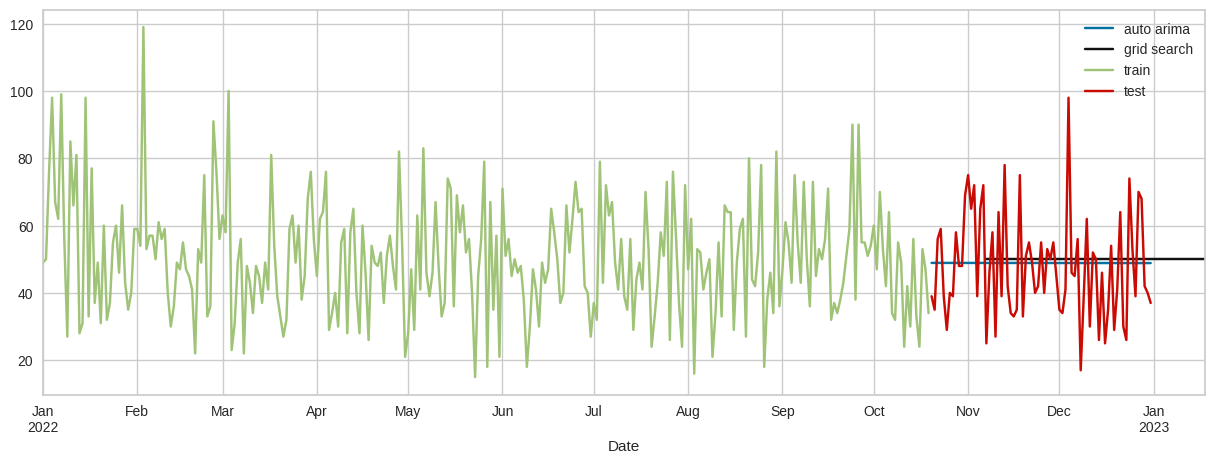

In [111]:
forecast.plot(label='auto arima', color = 'b', figsize = (15,5))
preds.plot(label='grid search', color = 'k', figsize = (15,5))

data_train.plot(label='train', color = 'g', figsize = (15,5))
data_test.plot(label='test', color = 'r', figsize = (15,5))
plt.legend()

Pada metode auto ARIMA dan mencari grid, dalam hal ini penggunaan grid search sepertinya lebih tepat.

# Model Evaluation

In [112]:
train_predictions = model_fit.predict(start=data_train.index[0], end=data_train.index[-1])
train_rmse = np.sqrt(mean_squared_error(data_train, train_predictions))

# Calculate RMSE for testing data
test_rmse = np.sqrt(mean_squared_error(data_test, preds))

print(f"RMSE for Training Data: {train_rmse:.2f}")
print(f"RMSE for Testing Data: {test_rmse:.2f}")

RMSE for Training Data: 17.40
RMSE for Testing Data: 15.68


<Axes: xlabel='Date'>

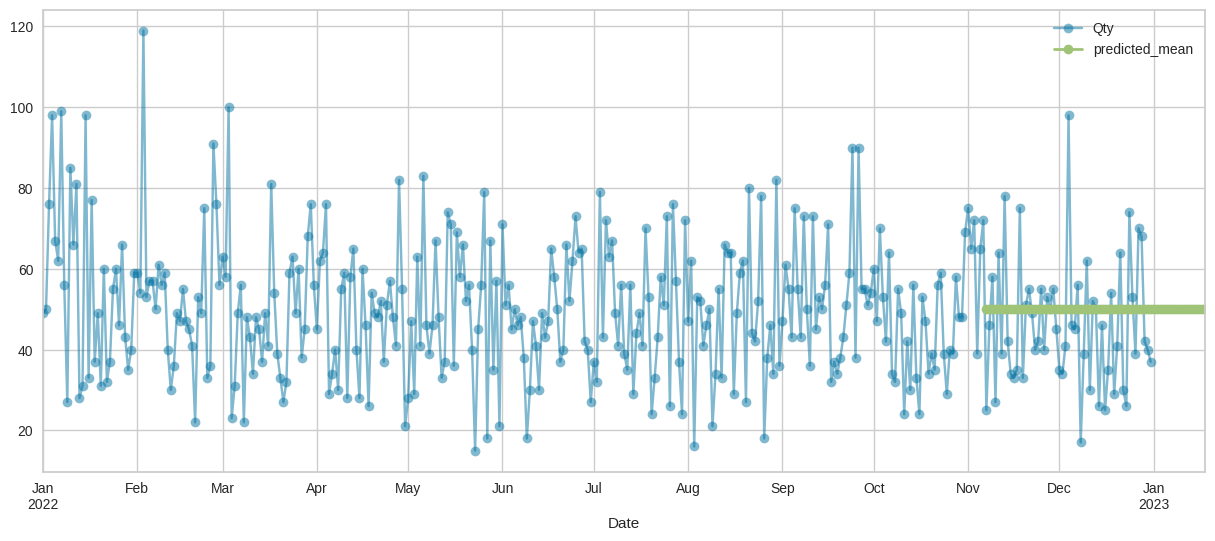

In [113]:
df_totalquantity.plot(figsize=(15, 6), alpha=0.5, marker="o")
preds.plot(linewidth=2, marker="o", legend=True)

# Forecasting

In [117]:
#Hyperparameter tuning
model_hyper = ARIMA(train, order=best_aic['par'])
model_fit_hyper = model_hyper.fit()

In [115]:
model_manual = ARIMA(train, order=(40,2,2))
model_fit_manual = model_manual.fit()

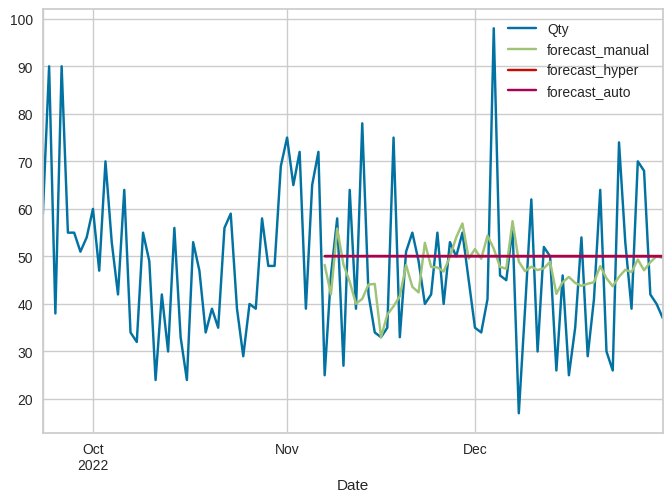

In [119]:
#plot forecasting
forecast_manual = model_fit_manual.forecast(len(test))
forecast_hyper = model_fit_hyper.forecast(len(test))
forecast_auto = auto_arima.predict(len(test))

df_plot = df_totalquantity.iloc[-100:]

df_plot['forecast_manual'] = [None]*(len(df_plot)-len(forecast_manual)) + list(forecast_manual)
df_plot['forecast_hyper'] = [None]*(len(df_plot)-len(forecast_hyper)) + list(forecast_hyper)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()
plt.show()

# Model Evaluation

In [120]:
#Manual parameter tuning metrics

mae = mean_absolute_error(test, forecast_manual)
mape = mean_absolute_percentage_error(test, forecast_manual)
rmse = np.sqrt(mean_squared_error(test, forecast_manual))

print(f'mae - manual: {round(mae,4)}')
print(f'mape - manual: {round(mape,4)}')
print(f'rmse - manual: {round(rmse,4)}')

mae - manual: 11.7652
mape - manual: 0.293
rmse - manual: 15.4831


Forecast with Best Parameter

In [123]:
#Apply model to forecast data
model = ARIMA(df_totalquantity, order=(40, 2, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

In [124]:
df_totalquantity

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


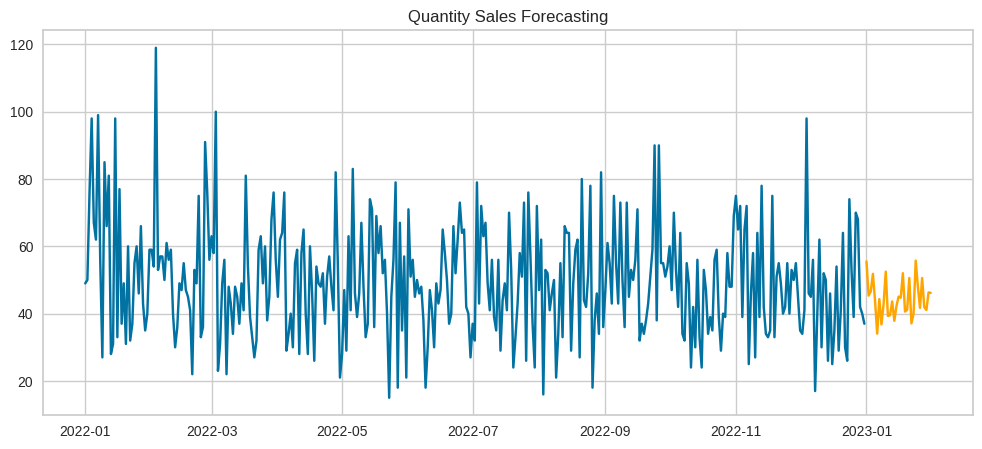

In [126]:
# Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_totalquantity)
plt.plot(forecast,color='orange')
plt.title('Quantity Sales Forecasting')
plt.show()

In [127]:
forecast.describe()

count    31.000000
mean     44.489775
std       5.541639
min      34.053507
25%      40.847933
50%      43.811827
75%      47.331878
max      55.767671
Name: predicted_mean, dtype: float64

Rata-rata penjualan pada Januari 2023 adalah 44.489775 atau sekitar 44 pcs/hari

# **Clustering**

In [128]:
df_merged.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,"10,53",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,"0,18",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,"4,36",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,"4,74",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,"9,94",Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554",Crackers


In [129]:
df_preclust = df_merged.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_preclust

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
439,442,13,37,269400
440,444,18,62,577700
441,445,18,68,587200
442,446,11,42,423300


In [130]:
df_preclust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     444 non-null    int64
 1   TransactionID  444 non-null    int64
 2   Qty            444 non-null    int64
 3   TotalAmount    444 non-null    int64
dtypes: int64(4)
memory usage: 14.0 KB


In [131]:
df_cluster = df_preclust.drop(columns = ['CustomerID'])
df_cluster.head()

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


In [132]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   TransactionID  444 non-null    int64
 1   Qty            444 non-null    int64
 2   TotalAmount    444 non-null    int64
dtypes: int64(3)
memory usage: 10.5 KB


In [133]:
df_cluster.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [134]:
#Standarisasi dataset
X = df_cluster.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_cluster.columns)
df_std.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [135]:
#Normalisasi dataset dengan minmaxscaler
X_norm = MinMaxScaler().fit_transform(X)
X_norm

array([[0.77777778, 0.72463768, 0.70394911],
       [0.55555556, 0.68115942, 0.39782666],
       [0.66666667, 0.66666667, 0.46925523],
       ...,
       [0.83333333, 0.84057971, 0.6561092 ],
       [0.44444444, 0.46376812, 0.43890803],
       [0.55555556, 0.46376812, 0.46011132]])

In [136]:
# Normalisasi dataset dengan preprocessing sklearn
X_norm2 = preprocessing.normalize(df_cluster)
X_norm2

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [137]:
X_std

array([[ 1.78828224,  1.50893374,  2.10242393],
       [ 0.55344971,  1.27289149,  0.24634281],
       [ 1.17086598,  1.19421074,  0.67942841],
       ...,
       [ 2.09699037,  2.13837973,  1.81236104],
       [-0.06396655,  0.09268025,  0.49542729],
       [ 0.55344971,  0.09268025,  0.62398702]])

In [138]:
df_std

,TransactionID,Qty,TotalAmount
0,1.788282,1.508934,2.102424
1,0.553450,1.272891,0.246343
2,1.170866,1.194211,0.679428
3,-0.372675,0.407403,-0.475199
4,-1.298799,-1.087531,-0.747585
...,...,...,...
439,0.553450,-0.300723,-0.741157
440,2.096990,1.666295,1.736029
441,2.096990,2.138380,1.812361
442,-0.063967,0.092680,0.495427


In [139]:
wcss= []
for n in range (1,11):
    model1 = KMeans(n_clusters=n, init='k-means++', n_init = 10, max_iter=100, tol =0.0001, random_state = 100)
    model1.fit(X_std)
    wcss.append(model1.inertia_)
print(wcss)

[1332.0000000000005, 543.4711248616254, 316.54668247055474, 237.60472575971139, 191.11956602309158, 169.32473141353285, 154.03936160517267, 142.48512585227888, 130.90829014139524, 121.69651564034504]


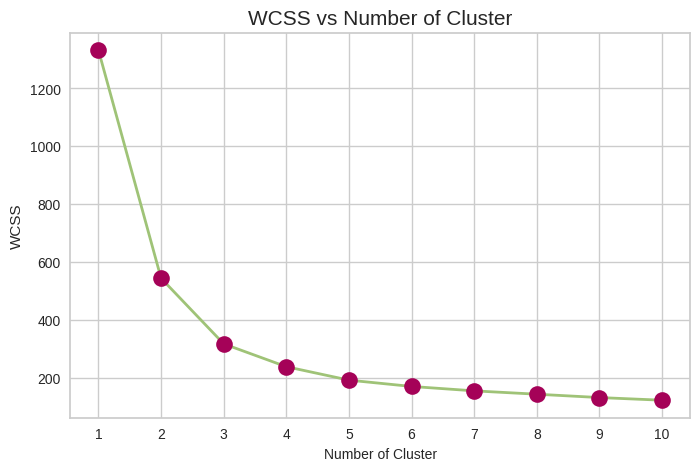

In [144]:
plt.figure(figsize=(8,5))
plt.plot(list(range(1,11)), wcss, color = 'g', marker = 'o', linewidth=2, markersize=12, markerfacecolor= 'm',
         markeredgecolor= 'r')
plt.title('WCSS vs Number of Cluster', fontsize = 15)
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

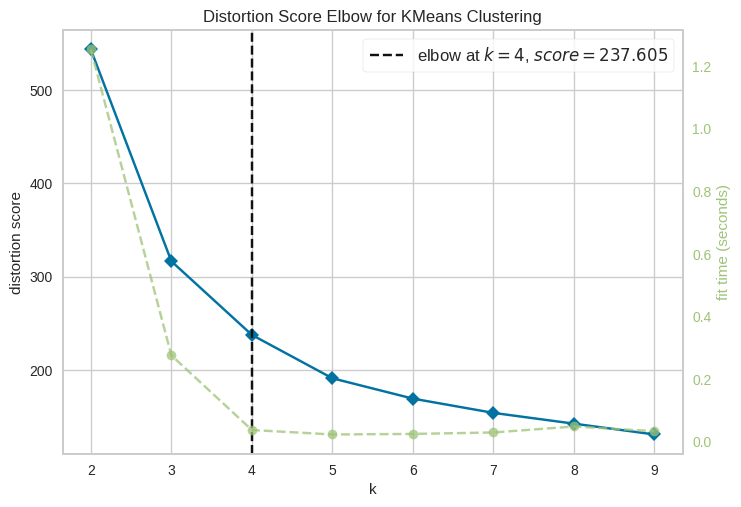

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [145]:
#Elbow Method with yellowbrick library
visualizer = KElbowVisualizer(model1, k=(2,10))
visualizer.fit(X_std)
visualizer.show()

In [146]:
K = range(2,8)
fits=[]
score=[]

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(X_std)
    fits.append(model)
    score.append(silhouette_score(X_std, model.labels_, metric='euclidean'))

<Axes: >

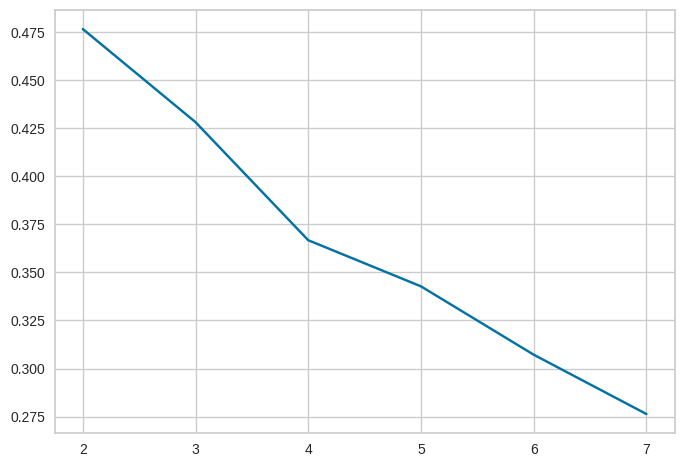

In [147]:
sns.lineplot(x = K, y = score)

K-Means

In [148]:
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=100)
kmeans_4.fit(X_std)

KMeans(n_clusters=4, n_init=10, random_state=100)

In [149]:
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.head()

,TransactionID,Qty,TotalAmount,cluster
0,17,60,623300,0
1,13,57,392300,2
2,15,56,446200,2
3,10,46,302500,3
4,7,27,268600,1


<Figure size 600x600 with 0 Axes>

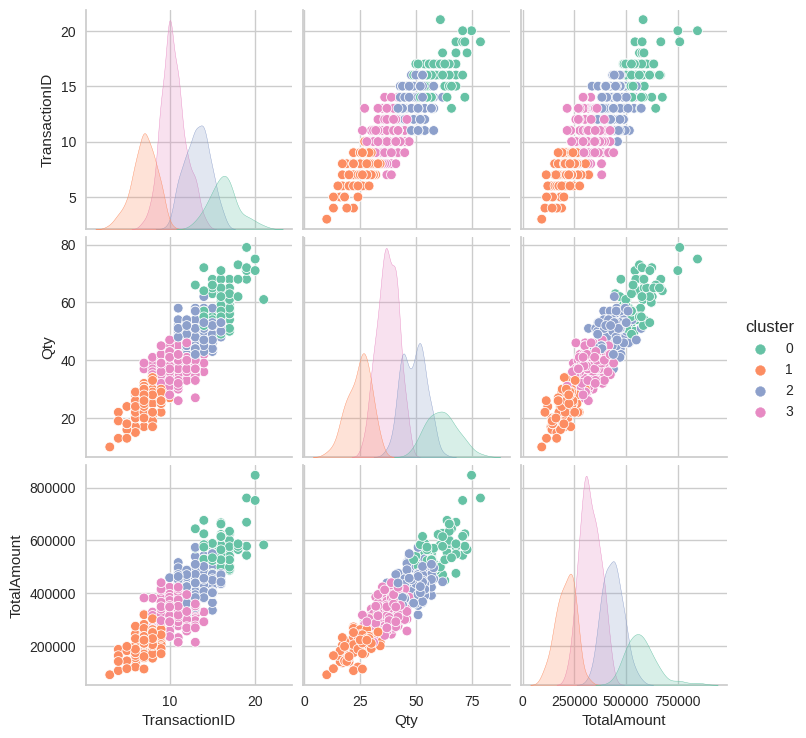

In [153]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='cluster',palette='Set2')
plt.show()

In [154]:
df_cluster['CustomerID'] = df_preclust['CustomerID']
df_cluster_mean = df_cluster.groupby('cluster').agg({'CustomerID':'count','TransactionID':'mean','Qty':'mean','TotalAmount':'mean'})
df_cluster_mean.sort_values('CustomerID', ascending = False)

,CustomerID,TransactionID,Qty,TotalAmount
cluster,,,,
3,180,10.427778,37.350000,325663.333333
2,113,13.247788,49.070796,435833.628319
1,93,7.021505,24.505376,208283.870968
0,58,16.362069,61.689655,574650.000000
